In [1]:
import wandb
from data_loaders import make_train_data, make_test_val_data, make_model
from train import train, test
import torch
import time
import gc
import config_file
from clean_data_seq2point import load_all_houses_with_device
import random
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from scipy.stats import skew
from scipy import stats
from sklearn.cluster import KMeans

In [2]:
appliance_dict = {"air1":"compressor",
                  "air2": "compressor",
                  "air3": "compressor",
                  "airwindowunit1":"air conditioner",
                  "aquarium1":"water pump",
                  "bathroom1":"sockets",
                  "bathroom2":"sockets",
                  "bedroom1":"sockets",
                  "bedroom2":"sockets",
                  "bedroom3":"sockets",
                  "bedroom4":"sockets",
                  "bedroom5":"sockets",
                  "battery1":"unknown",
                  "car1":"electric vehicle",
                  "car2":"electric vehicle",
                  "circpump1":"water pump",
                  "clotheswasher1":"washing machine",
                  "clotheswasher_dryg1":"washer dryer",
                  "diningroom1":"sockets",
                  "diningroom2":"sockets",
                  "dishwasher1":"dish washer",
                  "disposal1":"waste disposal unit",
                  "drye1":"tumble dryer",
                  "dryg1":"tumble dryer",
                  "freezer1":"freezer",
                  "furnace1":"electric furnace",
                  "furnace2":"electric furnace",
                  "garage1":"sockets",
                  "garage2":"sockets",
                  "heater1":"heating appliance",
                  "heater2":"heating appliance",
                  "heater3":"heating appliance",
                  "housefan1":"fan",
                  "icemaker1":"cold appliance",
                  "jacuzzi1":"jacuzzi pump",
                  "kitchen1":"sockets",
                  "kitchen2":"sockets",
                  "kitchenapp1":"sockets",
                  "kitchenapp2":"sockets",
                  "lights_plugs1":"light",
                  "lights_plugs2":"light",
                  "lights_plugs3":"light",
                  "lights_plugs4":"light",
                  "lights_plugs5":"light",
                  "lights_plugs6":"light",
                  "livingroom1":"sockets",
                  "livingroom2":"sockets",
                  "microwave1":"microwave",
                  "office1":"sockets",
                  "outsidelights_plugs1":"lighting component",
                  "outsidelights_plugs2":"lighting component",
                  "oven1":"oven",
                  "oven2":"oven",
                  "pool1":"electric swimming pool heater",
                  "pool2":"electric swimming pool heater",
                  "poollight1":"lighting component",
                  "poolpump1":"swimming pool pump",
                  "pump1":"water pump",
                  "range1":"stove",
                  "refrigerator1":"fridge",
                  "refrigerator2":"fridge",
                  "security1":"security alarm",
                  "sewerpump1":"water pump",
                  "shed1":"sockets",
                  "sprinkler1":"garden sprinkler",
                  "sumppump1":"water pump",
                  "utilityroom1":"subpanel",
                  "venthood1":"fan",
                  "waterheater1":"electric water heater",
                  "waterheater2":"electric water heater",
                  "wellpump1":"water pump",
                  "winecooler1":"cold appliance"
                 }

In [ ]:
path = r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_sept_oct_nov2019_new.csv"

In [ ]:
df = pd.read_csv(path)

In [ ]:
df = df.fillna(0)

In [ ]:
wanted = {'dataid', 'grid', 'solar', 'solar2'}

In [ ]:
grid = df.drop(columns=[x for x in df.columns if x not in wanted])

In [ ]:
grid = grid*1000
grid.dataid = grid.dataid/1000
grid.dataid = grid.dataid.astype('int32')

In [ ]:
df = df.drop(columns=['localminute', 'leg1v', 'leg2v', 'grid', 'solar', 'solar2', 'total_square_footage'])

In [ ]:
df = df*1000

In [ ]:
df.dataid = df.dataid/1000

In [ ]:
df.dataid = df.dataid.astype('int32')

In [ ]:
len(df)

In [ ]:
df_new = df.groupby(df.dataid).sum()

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(df_new.where(df_new == 0, 1), xticklabels=True, yticklabels=True, ax=ax)

In [ ]:
app_distribution = pd.DataFrame([df_new.columns, np.count_nonzero(df_new, axis=0)/df_new.shape[0]]).transpose()

In [ ]:
app_distribution = app_distribution.sort_values(by=[1], ascending=False).reset_index(drop=True)

In [ ]:
#plot to show the percent of buildings that contain each appliance type
plt.figure(figsize=(12,5))
plt.bar(app_distribution[0][0:54], app_distribution[1][0:54])
plt.xticks(rotation=90)
plt.xlabel("Appliance Name")
plt.ylabel("Percent of homes metering each appliance")
plt.savefig('appliance_percents.png')

In [ ]:
appliances_per_building = pd.DataFrame([df_new.index, np.count_nonzero(df_new, axis=1)]).transpose()

In [ ]:
appliances_per_building = appliances_per_building.sort_values(by=[1], ascending=False).reset_index(drop=True)

In [ ]:
#plot to show how many appliances each building is metering
plt.figure(figsize=(20,5))
plt.bar(appliances_per_building[0].astype('str'), appliances_per_building[1])
plt.xticks(rotation=90)

In [ ]:
grid['total_grid'] = grid['grid'] + grid['solar'] + grid['solar2']

In [ ]:
grid.groupby(grid.dataid).sum()

In [ ]:
grid['total_grid'] = grid['total_grid'].mask(grid['total_grid'] > 30000, 0)

In [ ]:
grid['total_grid'] = grid['total_grid'].mask(grid['total_grid'] < 0, 0)

In [ ]:
df_new

In [ ]:
app_power_percents = df_new.div(grid.groupby(grid.dataid).sum().total_grid.values, axis=0)

In [ ]:
#plot to show percent of total power that each house is submetering
plt.figure(figsize=(20,5))
plt.bar(app_power_percents.sum(axis=1).sort_values(ascending=False).index.astype('str'), app_power_percents.sum(axis=1).sort_values(ascending=False).values)
plt.xticks(rotation=90)

In [ ]:
app_power_percents.sum(axis=1).sort_values(ascending=False).index.astype('str')

In [ ]:
df_avg = df.groupby(df.dataid).mean()

In [ ]:
#average power consumption by appliance
plt.figure(figsize=(20,5))
plt.bar(df_avg.mean(axis=0).sort_values(ascending=False).index[0:50], df_avg.mean(axis=0).sort_values(ascending=False).values[0:50])
plt.xticks(rotation=90)

In [ ]:
app_distribution_new = pd.DataFrame([df_new.columns, np.count_nonzero(df_new, axis=0)/df_new.shape[0]]).transpose()

In [ ]:
app_distribution_new

In [ ]:
app_distribution_new[1] = app_distribution_new[1]*df_avg.mean(axis=0).values

In [ ]:
app_distribution_new = app_distribution_new.sort_values(by=1,ascending=False).reset_index(drop=True)

In [ ]:
#plot showing average power consumption * percent of buildings containing each appliance
plt.figure(figsize=(12,5))
plt.bar(app_distribution_new[0], app_distribution_new[1])
plt.xticks(rotation=90)

In [ ]:
lengths = df.pivot_table(columns=['dataid'], aggfunc='size').sort_values(ascending=False)

In [ ]:
#dataset lengths for each home
plt.figure(figsize=(20,5))
plt.bar(lengths.index.astype('str'), lengths.values)
plt.xticks(rotation=90)

In [ ]:
total_grid_power = grid.groupby(grid.dataid).sum().sort_values(by='total_grid', ascending=False)

In [ ]:
total_grid_power

In [ ]:
#normalized total power consumption for all houses
plt.figure(figsize=(20,5))
plt.bar(total_grid_power.index.astype('str'), 
         (total_grid_power.total_grid/max(total_grid_power.total_grid)).values)
plt.xticks(rotation=90)

In [ ]:
#plots for appliance power consumption for each house
for column in df_avg.columns:
    appliance = df_avg.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [ ]:
appliance_over_mains = df_avg.div(total_grid_power.total_grid.sort_index().values, axis=0)

In [ ]:
#plots for appliance/mains power consumption for each home (relative to entire home)
for column in appliance_over_mains.columns:
    appliance = appliance_over_mains.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [ ]:
#appliance_over_mains['refrigerator1'].to_csv(r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\refrigerator_over_mains")

In [ ]:
df_time_lengths = pd.read_csv(path, usecols = ['dataid', 'localminute'])

In [ ]:
df_time_lengths['localminute']= pd.to_datetime(df_time_lengths['localminute'])

In [ ]:
df_time_lengths_ids = df_time_lengths.dataid.unique()

In [ ]:
min_max_times = {}
for i in df_time_lengths_ids:
    df_temp = df_time_lengths.loc[df_time_lengths.dataid == i]
    min_max_times.update({i:[min(df_temp.localminute), max(df_temp.localminute)]})

In [ ]:
df_time_lengths_new = pd.DataFrame(min_max_times).transpose()

In [ ]:
df_time_lengths_new['time_differences'] = df_time_lengths_new[1] - df_time_lengths_new[0]

In [ ]:
df_time_lengths_new = df_time_lengths_new.sort_values(by='time_differences', ascending=True)

In [ ]:
plt.figure(figsize=(20,20))
plt.hlines(df_time_lengths_new.index.astype(str), df_time_lengths_new[0], df_time_lengths_new[1])
plt.xticks(rotation=90)

In [5]:
path_dec = r"C:\Users\aar245\Desktop\input\1min_real_dec2019.csv"

In [ ]:
df_dec = pd.read_csv(path_dec, usecols = ['dataid', 'localminute'])

In [ ]:
df_dec['localminute']= pd.to_datetime(df_dec['localminute'])

In [ ]:
df_dec_ids = df_dec.dataid.unique()

In [ ]:
min_max_times_dec = {}
for i in df_dec_ids:
    df_temp = df_dec.loc[df_dec.dataid == i]
    min_max_times_dec.update({i:[min(df_temp.localminute), max(df_temp.localminute)]})

In [ ]:
df_dec_new = pd.DataFrame(min_max_times_dec).transpose()

In [ ]:
df_dec_new['time_differences'] = df_dec_new[1] - df_dec_new[0]

In [ ]:
df_dec_new = df_dec_new.sort_values(by='time_differences', ascending=True)

In [ ]:
plt.figure(figsize=(20,20))
plt.hlines(df_dec_new.index.astype(str), df_dec_new[0], df_dec_new[1])
plt.xticks(rotation=90)

In [ ]:
list1 = df_dec_new.index

In [ ]:
list2 = df_time_lengths_new.index

In [ ]:
df.dataid.unique()

In [ ]:
df[df < 10].groupby(df.dataid).count()

In [ ]:
#time spent on for each appliance
df[df > 100].groupby(df.dataid).count().div(df.groupby(df.dataid).count())

## Aggregate power summary

In [ ]:
#Max aggregate power per home
max_grid_power = grid.groupby(grid.dataid).max().sort_values(by='total_grid',ascending=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(max_grid_power.index.astype('str'), max_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [ ]:
#Min aggregate power per home
min_grid_power = grid.groupby(grid.dataid).min().sort_values(by='total_grid',ascending=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(min_grid_power.index.astype('str'), min_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [ ]:
#Max - min aggregate power per home (range)
range_grid_power = grid.groupby(grid.dataid).max() - grid.groupby(grid.dataid).min()

In [ ]:
range_grid_power = range_grid_power.sort_values(by='total_grid',ascending=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(range_grid_power.index.astype('str'), range_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [ ]:
#Avg aggregate power per home
avg_grid_power = grid.groupby(grid.dataid).mean().sort_values(by='total_grid',ascending=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(avg_grid_power.index.astype('str'), avg_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [ ]:
data_ids = grid.dataid.unique()

In [ ]:
df_avg_on = df.set_index(df.dataid)

In [ ]:
df_avg_on = df_avg_on.drop(columns=['dataid'])

In [ ]:
df_avg_on = df_avg_on.groupby(df_avg_on.index).mean().fillna(0)

In [ ]:
power_ratios = df_avg_on.div(avg_grid_power.sort_index()['total_grid'], axis=0)

In [ ]:
#plots for appliance/mains power consumption for each home (relative to entire home)
for column in power_ratios.columns:
    appliance = power_ratios.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [ ]:
train_results = pd.DataFrame({'refrigerator1_Train_home_[145]_Test_home_[145]_train_results': [0.02783979018706651, 0.9721301322037477, 0.9204460255908976, 0.15909073010321598, 0.01877287176348396, 10.441416122890123, 247.7403], 'refrigerator1_Train_home_[183]_Test_home_[183]_train_results': [0.028937786255242688, 0.9710550204607582, 0.9369042982455359, 0.12618883368950068, 0.015082493644559736, 8.99731967029819, 160.09944], 'refrigerator1_Train_home_[335]_Test_home_[335]_train_results': [0.08356140624239759, 0.9163628675606516, 0.8959689369237326, 0.20800617122898157, 0.041714718499691134, 14.452754280649007, 401.78247], 'refrigerator1_Train_home_[387]_Test_home_[387]_train_results': [0.020404181049133722, 0.9795846079349255, 0.9358621992435974, 0.12826396081022096, 0.013247373326495995, 5.664247783143722, 73.58063], 'refrigerator1_Train_home_[526]_Test_home_[526]_train_results': [0.07508077177236665, 0.9248836200859084, 0.9220419102378201, 0.1558509966470338, 0.028745347046469808, 14.333907399675848, 393.88138], 'refrigerator1_Train_home_[1417]_Test_home_[1417]_train_results': [0.026683574472114724, 0.9732745549453803, 0.9080304380432874, 0.18387717793781175, 0.019421255039264923, 8.344925613345126, 146.359], 'refrigerator1_Train_home_[2358]_Test_home_[2358]_train_results': [0.01359422487329762, 0.9863958705258896, 0.9431267352464042, 0.11373066631707417, 0.009727612234148239, 4.781343052047159, 60.33647], 'refrigerator1_Train_home_[3383]_Test_home_[3383]_train_results': [0.01371692897716783, 0.9862856265567773, 0.9354973290925032, 0.1290295868800677, 0.010295623574333144, 4.273204024203582, 45.299133], 'refrigerator1_Train_home_[4628]_Test_home_[4628]_train_results': [0.030287155299447477, 0.9697702819748668, 0.9010721094764037, 0.19774339112877912, 0.022915632032538977, 5.618060556222464, 76.44952], 'refrigerator1_Train_home_[6240]_Test_home_[6240]_train_results': [0.01564209261592829, 0.9843631389712315, 0.936213309001166, 0.1275820818610395, 0.011471476779876748, 4.45089020697785, 52.411697], 'refrigerator1_Train_home_[6526]_Test_home_[6526]_train_results': [0.027992234512601258, 0.9720264553163508, 0.9483407074918249, 0.10331240987360527, 0.012747851265268966, 7.54853344269148, 125.03384], 'refrigerator1_Train_home_[6672]_Test_home_[6672]_train_results': [0.04690615783603686, 0.953057658553026, 0.9045751217098925, 0.19088325714809887, 0.030360809109380802, 8.910903647384236, 187.31012], 'refrigerator1_Train_home_[7021]_Test_home_[7021]_train_results': [0.05747514471130551, 0.9425310835312702, 0.8839052238549321, 0.23220801169091107, 0.037166057419669295, 11.761480980996046, 269.89322], 'refrigerator1_Train_home_[7069]_Test_home_[7069]_train_results': [0.02681264474566253, 0.9731551843244872, 0.9168886997604214, 0.16625818244859208, 0.018576142538911076, 8.962709761953462, 175.264], 'refrigerator1_Train_home_[7365]_Test_home_[7365]_train_results': [0.07312433646534974, 0.9269558487126387, 0.9167806599142788, 0.16643328728382337, 0.030898092624396453, 10.316130685769902, 205.73747], 'refrigerator1_Train_home_[9004]_Test_home_[9004]_train_results': [0.07930011583386727, 0.9206539695681408, 0.9153200294545824, 0.16928633829708709, 0.03275940270328144, 8.778304979977582, 150.02975], 'refrigerator1_Train_home_[10554]_Test_home_[10554]_train_results': [0.027339812809307324, 0.9726687684455291, 0.9088810999958422, 0.18223611937379539, 0.019443006796130854, 8.114437542067227, 133.56456], 'refrigerator1_Train_home_[10811]_Test_home_[10811]_train_results': [0.005470082647044142, 0.9945248346744348, 0.9784730849447741, 0.04305445894972802, 0.0025301331181310843, 3.7568558970086907, 35.81486], 'refrigerator1_Train_home_[10983]_Test_home_[10983]_train_results': [0.008610825317929376, 0.9913812765885781, 0.9561675320085052, 0.08766533263267277, 0.005895966794847629, 4.943452785573417, 59.34638], 'refrigerator1_Train_home_[11878]_Test_home_[11878]_train_results': [0.08324884693577604, 0.9168318984660124, 0.9413874796036258, 0.11721454600903414, 0.02260666185207276, 8.83389526594149, 176.33498], 'refrigerator1_Train_home_[142]_Test_home_[142]_train_results': [0.021514983812593064, 0.9784785791471589, 0.9304145238307865, 0.13916095514769597, 0.013589186584865276, 7.006772135087863, 93.46953], 'refrigerator1_Train_home_[690]_Test_home_[690]_train_results': [0.06669498509112394, 0.9333489814380148, 0.8774522956882744, 0.245079845564538, 0.04386009742476431, 11.433412237872975, 279.15866], 'refrigerator1_Train_home_[950]_Test_home_[950]_train_results': [0.07220264685884961, 0.9276615284021814, 0.8968259063654939, 0.20621964277777452, 0.03920382703175028, 14.788760917192192, 440.16855], 'refrigerator1_Train_home_[984]_Test_home_[984]_train_results': [0.10333451403761809, 0.8966265380280765, 0.9155807057088337, 0.16878335818407406, 0.03669932033125471, 11.492184591809817, 263.78833], 'refrigerator1_Train_home_[1240]_Test_home_[1240]_train_results': [0.06738317497777489, 0.932618935631404, 0.8909194583475055, 0.21812614502603808, 0.03970241466153994, 10.511407419491324, 224.44824], 'refrigerator1_Train_home_[1249]_Test_home_[1249]_train_results': [0.1267141711037114, 0.8731876713553657, 0.8528383686786661, 0.29432458304692766, 0.06985011019769123, 21.27727414606183, 812.68195], 'refrigerator1_Train_home_[2126]_Test_home_[2126]_train_results': [0.07720691612306631, 0.9227209811950958, 0.8805513442888917, 0.2388237379136857, 0.047084896383396434, 9.067731128433659, 173.7253], 'refrigerator1_Train_home_[2561]_Test_home_[2561]_train_results': [0.12901024731262675, 0.8708007719173206, 0.7813616115359395, 0.43687979219971457, 0.10155344665889907, 24.993256893725363, 1553.2719], 'refrigerator1_Train_home_[3344]_Test_home_[3344]_train_results': [0.15320747728858675, 0.8467877534842394, 0.8872235524445946, 0.22541437846282472, 0.08528623270386869, 12.723628105168824, 612.90753], 'refrigerator1_Train_home_[3488]_Test_home_[3488]_train_results': [0.07955750035789777, 0.9203088329647195, 0.9021820148939271, 0.1956036368674816, 0.03725680263901125, 9.605900642284448, 168.74092], 'refrigerator1_Train_home_[3700]_Test_home_[3700]_train_results': [0.045657490643690214, 0.9542508540572363, 0.9346643228632749, 0.13065869354047085, 0.026416822981252384, 6.303817514613055, 145.51584], 'refrigerator1_Train_home_[3976]_Test_home_[3976]_train_results': [0.08868329972028732, 0.9113262646942543, 0.8629059219316927, 0.27399131077475647, 0.05737063855454058, 13.141353394471842, 373.85565], 'refrigerator1_Train_home_[3996]_Test_home_[3996]_train_results': [0.06759641256253675, 0.9324633794328021, 0.908901374504913, 0.18223994560232382, 0.032885009537993413, 8.46276712656203, 138.21382], 'refrigerator1_Train_home_[5058]_Test_home_[5058]_train_results': [0.021853400710618722, 0.9781268476310025, 0.9209593987755592, 0.1580642181330198, 0.01610689595074571, 4.55184688997305, 50.668434], 'refrigerator1_Train_home_[5192]_Test_home_[5192]_train_results': [0.11898263164286343, 0.8809474895755488, 0.9021650096043677, 0.1955591309204376, 0.044600413645737025, 15.78053144785214, 464.39493], 'refrigerator1_Train_home_[5367]_Test_home_[5367]_train_results': [0.08151739470238956, 0.9185122533203791, 0.8748640888253916, 0.2503445143501339, 0.04840429900057814, 15.610893864809876, 463.6016], 'refrigerator1_Train_home_[5982]_Test_home_[5982]_train_results': [0.11066815144610855, 0.8891634613061677, 0.9048132089023321, 0.1903904473794735, 0.04403651757401522, 18.413653515510937, 683.45337], 'refrigerator1_Train_home_[6069]_Test_home_[6069]_train_results': [0.07777450163409395, 0.9220362333943324, 0.8401666384310413, 0.31939032902776665, 0.05784917493421125, 9.798868128022194, 211.05083], 'refrigerator1_Train_home_[6178]_Test_home_[6178]_train_results': [0.027761443641107036, 0.972218025434357, 0.9239185579258443, 0.15222937510815693, 0.016935242598523068, 9.64868329235109, 174.25882], 'refrigerator1_Train_home_[6564]_Test_home_[6564]_train_results': [0.01521659255871233, 0.9848216095805677, 0.9536323348227322, 0.09274640380388673, 0.0078054818143435825, 6.66436110990453, 82.96778], 'refrigerator1_Train_home_[6594]_Test_home_[6594]_train_results': [0.1239715817401994, 0.8761915484356178, 0.9235423249123493, 0.15290293607239713, 0.035131195021535305, 13.729432211380528, 395.46173], 'refrigerator1_Train_home_[6703]_Test_home_[6703]_train_results': [0.09699859723167599, 0.9029024866844028, 0.8497213691481577, 0.30055859091927867, 0.06235669596242196, 15.70448617919177, 475.8174], 'refrigerator1_Train_home_[6907]_Test_home_[6907]_train_results': [0.10037614883116956, 0.8996576337954104, 0.8601882651111133, 0.27970013840580554, 0.06012577049284931, 13.554223903260278, 352.2927], 'refrigerator1_Train_home_[7935]_Test_home_[7935]_train_results': [0.09502874356958102, 0.9050508090041272, 0.9314639083270047, 0.13703839521308134, 0.030102094892843535, 10.66593349078518, 266.99963], 'refrigerator1_Train_home_[8162]_Test_home_[8162]_train_results': [0.09078615482123394, 0.9091269447601552, 0.8221578104181828, 0.3552554045382493, 0.06828957632798134, 9.467095749460041, 195.14204], 'refrigerator1_Train_home_[8627]_Test_home_[8627]_train_results': [0.07929097383089785, 0.9207501133550016, 0.8558615383351099, 0.28814187196744523, 0.053497504766045124, 11.601572019691963, 266.8921], 'refrigerator1_Train_home_[8825]_Test_home_[8825]_train_results': [0.04052925074719033, 0.9595766931394142, 0.8234366564859261, 0.35313413026606294, 0.035762439730019566, 13.82600659112181, 475.45148], 'refrigerator1_Train_home_[8849]_Test_home_[8849]_train_results': [0.0813511073027017, 0.9186290349004559, 0.9153493751650711, 0.16923814573754586, 0.03135698756257074, 7.112244045336132, 90.1009], 'refrigerator1_Train_home_[9002]_Test_home_[9002]_train_results': [0.07585446466252489, 0.924019194009471, 0.8759567325076547, 0.24808395353449042, 0.046935919492534096, 11.942377380833745, 284.5272], 'refrigerator1_Train_home_[9053]_Test_home_[9053]_train_results': [0.06737977442032886, 0.9326958443635078, 0.8955601887200326, 0.20883379406751945, 0.039256007386666666, 12.458103429821954, 335.2325], 'refrigerator1_Train_home_[9290]_Test_home_[9290]_train_results': [0.09653490795841757, 0.9034558777652026, 0.8555695662835933, 0.2886743539685051, 0.06090143941313755, 3.1390660640758745, 19.505968], 'refrigerator1_Train_home_[9973]_Test_home_[9973]_train_results': [0.13311332534506637, 0.8669162857206942, 0.8173415911505385, 0.3658366295081658, 0.09166787366413133, 12.109957035873611, 322.76498], 'refrigerator1_Train_home_[10164]_Test_home_[10164]_train_results': [0.10322719432835309, 0.8967204510150439, 0.8313797079720934, 0.33762331827412334, 0.0736023688947681, 11.399270609601775, 291.99316], 'refrigerator1_Train_home_[10182]_Test_home_[10182]_train_results': [0.067881130666103, 0.9321138887299864, 0.8991503615454577, 0.20168393789907266, 0.03598067821878201, 12.961112889974377, 316.17502], 'refrigerator1_Train_home_[11421]_Test_home_[11421]_train_results': [0.1902449088838865, 0.8088373587545801, 0.8421011206163482, 0.3156205737112428, 0.13059830609919676, 22.21732953663698, 2042.569], 'refrigerator1_Train_home_[11785]_Test_home_[11785]_train_results': [0.0850063516002781, 0.9149007775179567, 0.8356005441448611, 0.3285194051690052, 0.061905228133014786, 10.732849248614047, 242.42944]}).T

In [ ]:
test_results = pd.DataFrame({'refrigerator1_Train_home_[145]_Test_home_[145]_test_results': [0.8083785772323608, 0.2667552706986388, 0.5895951825531386, 0.7504243251975439, 0.5363781216656092, 40.36012583625219, 5778.821], 'refrigerator1_Train_home_[183]_Test_home_[183]_test_results': [0.5604396296872033, 0.42962543938467224, 0.7662272592896554, 0.46146469607513413, 0.2543232217076343, 37.63015093205223, 3051.993], 'refrigerator1_Train_home_[335]_Test_home_[335]_test_results': [0.7162614597214593, 0.27159488766139295, 0.6736659676021461, 0.6569726825064622, 0.3878528997248897, 41.33261799009043, 3283.5796], 'refrigerator1_Train_home_[387]_Test_home_[387]_test_results': [0.4910731166601181, 0.5067189250749174, 0.6376572941891011, 0.673717048015187, 0.3386481502627396, 24.626048441087047, 1443.3628], 'refrigerator1_Train_home_[526]_Test_home_[526]_test_results': [0.7317408819993337, 0.27914194719483687, 0.7671688040953207, 0.4824234173105178, 0.27646405232685767, 43.60487334958969, 3663.815], 'refrigerator1_Train_home_[1417]_Test_home_[1417]_test_results': [0.7434883183903165, 0.19083120205750703, 0.4881456508911904, 0.9254203784289637, 0.6089521304489484, 34.192085243980515, 3359.658], 'refrigerator1_Train_home_[2358]_Test_home_[2358]_test_results': [0.36540838165415657, 0.6325620195406383, 0.6314227325851938, 0.6182139933799707, 0.28578529475066783, 20.208645537164475, 1374.2006], 'refrigerator1_Train_home_[3383]_Test_home_[3383]_test_results': [0.13482176760832468, 0.8548827292109543, 0.7683326195201391, 0.46585908893351924, 0.11887928278750445, 11.006087951036337, 366.98776], 'refrigerator1_Train_home_[4628]_Test_home_[4628]_test_results': [0.6649149656295776, 0.2940571996162785, 0.5794566453542057, 0.8254895271696331, 0.48607006916581474, 28.566412739258087, 1868.8966], 'refrigerator1_Train_home_[6240]_Test_home_[6240]_test_results': [0.20339538891696268, 0.7868752668732224, 0.7387428343428958, 0.48678692865821743, 0.17335265490327684, 11.79263145145977, 545.1672], 'refrigerator1_Train_home_[6526]_Test_home_[6526]_test_results': [0.27722299264536965, 0.7153176412175875, 0.7935980794358313, 0.3980247084052653, 0.1579698642639406, 23.106671768277348, 1196.107], 'refrigerator1_Train_home_[6672]_Test_home_[6672]_test_results': [0.6442988249990675, 0.34030199439651754, 0.6173003049567214, 0.7268857989949551, 0.4397031433150924, 30.632504712467124, 2341.6655], 'refrigerator1_Train_home_[7021]_Test_home_[7021]_test_results': [0.8322225511074066, 0.22732249968865414, 0.593414468531086, 0.7190813377381942, 0.42498853981095386, 49.6595897737797, 4504.378], 'refrigerator1_Train_home_[7069]_Test_home_[7069]_test_results': [1.0131712489657931, -0.013149011069744532, 0.4144242361735212, 0.984036521328224, 0.6910614887542049, 50.78470527630126, 5789.746], 'refrigerator1_Train_home_[7365]_Test_home_[7365]_test_results': [0.712006977862782, -0.1481327266243837, 0.8531188043269946, 0.28183553660292443, 0.1315037193827105, 24.881090200930085, 1157.484], 'refrigerator1_Train_home_[9004]_Test_home_[9004]_test_results': [0.9708375533421835, 0.0964404356233074, 0.7017529860727468, 0.6112819635583524, 0.4116560526384758, 28.862888293112476, 1685.8068], 'refrigerator1_Train_home_[10554]_Test_home_[10554]_test_results': [0.7697020437982347, 0.18720563317484584, 0.37377515181110815, 1.1713806854955875, 0.6523644798778222, 35.50396078777997, 3036.2896], 'refrigerator1_Train_home_[10811]_Test_home_[10811]_test_results': [0.5069286326567332, 0.49276347023543143, 0.7871248747449184, 0.3801390393530446, 0.24527489464555632, 30.774077586888414, 3112.5125], 'refrigerator1_Train_home_[10983]_Test_home_[10983]_test_results': [0.1722663115296099, 0.826343036974159, 0.8330455293979624, 0.31762617503497753, 0.12227470619701128, 16.716586160745244, 1144.6646], 'refrigerator1_Train_home_[11878]_Test_home_[11878]_test_results': [0.5366702427466711, 0.43101166238230926, 0.8353528178360826, 0.32403138121958974, 0.18275223833689697, 20.499645014133932, 1077.5359], 'refrigerator1_Train_home_[142]_Test_home_[142]_test_results': [0.68933148516549, 0.202729327889268, 0.5844919612359883, 0.802221764207449, 0.48695804969903356, 42.12940193342052, 3450.4802], 'refrigerator1_Train_home_[690]_Test_home_[690]_test_results': [1.0669424931208293, -0.0325577370808221, 0.45639139478974133, 1.0238567116472772, 0.6313550039390633, 53.99752407979794, 4519.5312], 'refrigerator1_Train_home_[950]_Test_home_[950]_test_results': [1.0405481722619798, -0.008461270167096524, 0.5799443324567142, 0.8162527560230675, 0.4914197501659339, 68.4496688196736, 6740.309], 'refrigerator1_Train_home_[984]_Test_home_[984]_test_results': [0.06662690204878648, 0.0, 0, 0, 0, 3.395229039578882, 26.630695], 'refrigerator1_Train_home_[1240]_Test_home_[1240]_test_results': [0.8484935760498047, -0.028780849271243136, 0.5399570826817751, 0.9360426529195678, 0.6520488179621013, 37.36739305415888, 2837.6885], 'refrigerator1_Train_home_[1249]_Test_home_[1249]_test_results': [1.0974906153149075, -0.05778683914597016, 0.37256291887699755, 1.1039004419901617, 0.715002161027059, 45.73975871694558, 3788.0178], 'refrigerator1_Train_home_[2126]_Test_home_[2126]_test_results': [0.7268699275122749, 0.11855051892514734, 0.5324395452099362, 0.9817550860041386, 0.6117673945685047, 25.882662019251068, 1389.7708], 'refrigerator1_Train_home_[2561]_Test_home_[2561]_test_results': [0.9004512495464749, 0.0015355779793911895, 0.37555782350989614, 1.294569160860666, 0.8504668869945962, 63.71983089985386, 13900.619], 'refrigerator1_Train_home_[3344]_Test_home_[3344]_test_results': [1.2292303144931793, -0.009522301135777234, 0.7667750498953702, 0.44477187671611607, 0.517162249337053, 29.5590335039659, 4683.448], 'refrigerator1_Train_home_[3488]_Test_home_[3488]_test_results': [1.0368920101059809, 0.02757827011853331, 0.6298059906506396, 0.7233254673456125, 0.4595229308918016, 35.78153675884329, 2131.9678], 'refrigerator1_Train_home_[3700]_Test_home_[3700]_test_results': [0.5825970272223154, 0.4266328007830169, 0.7521906312127296, 0.4717874303997443, 0.36899270225730935, 18.88043829830744, 1657.8885], 'refrigerator1_Train_home_[3976]_Test_home_[3976]_test_results': [0.8601872656080458, 0.026559171540500026, 0.3685736180738197, 1.096387042106857, 0.7176894794533756, 40.26967565687962, 3685.162], 'refrigerator1_Train_home_[3996]_Test_home_[3996]_test_results': [1.0944173402256436, -0.20773099688372687, 0.5258491707629546, 1.0612253561847733, 0.7007596468570443, 33.41490549631016, 1655.0881], 'refrigerator1_Train_home_[5058]_Test_home_[5058]_test_results': [0.6780554155508677, 0.28336437868581565, 0.5135137154524643, 0.9314021936149718, 0.5111832923418177, 25.889684287920648, 1377.663], 'refrigerator1_Train_home_[5192]_Test_home_[5192]_test_results': [1.0182836188210382, -0.004188690194150135, 0.7247926397916853, 0.5593910546825881, 0.3764374993244226, 46.64491833153591, 4186.955], 'refrigerator1_Train_home_[5367]_Test_home_[5367]_test_results': [0.8501269353760613, 0.08152244383517493, 0.4988838708017318, 1.0274468963685073, 0.5875870162018215, 53.36026120732762, 4399.198], 'refrigerator1_Train_home_[5982]_Test_home_[5982]_test_results': [0.9819606410132514, 0.050841597712885434, 0.7156174123995899, 0.5480084611507532, 0.34760771176252137, 50.696135018632404, 4693.87], 'refrigerator1_Train_home_[6069]_Test_home_[6069]_test_results': [0.9588367607858446, -0.0045713541570227, 0.3377551421391348, 1.3769477591258936, 0.7670285852985708, 37.37234718773955, 2389.5513], 'refrigerator1_Train_home_[6178]_Test_home_[6178]_test_results': [0.7529306411743164, 0.24478724360775672, 0.4898357397242832, 0.9569067576038902, 0.5236532096479626, 48.87684255244484, 4455.715], 'refrigerator1_Train_home_[6564]_Test_home_[6564]_test_results': [0.6175155176056756, 0.3883375004782026, 0.6775248910748867, 0.6350632520587438, 0.3393098234729235, 39.750179528335515, 2985.526], 'refrigerator1_Train_home_[6594]_Test_home_[6594]_test_results': [0.9146241611904569, 0.09570239733226282, 0.8005366358759209, 0.39313518463818187, 0.28252139145684513, 31.454865892984532, 2630.3918], 'refrigerator1_Train_home_[6703]_Test_home_[6703]_test_results': [1.040198094314999, -0.008962202861320323, 0.39444000619580183, 1.1493854478942096, 0.6589554335395059, 54.84592370610938, 4325.2563], 'refrigerator1_Train_home_[6907]_Test_home_[6907]_test_results': [1.0165290964974298, -0.025449345556510572, 0.49667947708083277, 1.0311718651112298, 0.6762591419789843, 42.24450565854281, 3333.0637], 'refrigerator1_Train_home_[7935]_Test_home_[7935]_test_results': [0.9817998674180772, 0.006276101974870274, 0.8344717152311041, 0.3329665713634402, 0.34693853207472203, 24.181100537016402, 2811.3113], 'refrigerator1_Train_home_[8162]_Test_home_[8162]_test_results': [1.065514001581404, -0.00920740147921939, 0.29440503234690196, 1.3625278568691974, 0.7303822597853689, 38.74010991281079, 2137.1233], 'refrigerator1_Train_home_[8627]_Test_home_[8627]_test_results': [1.0450127522150676, -0.06560711833153032, 0.3290214004531558, 1.30550734370425, 0.7597963607281071, 46.47167464832251, 3354.7456], 'refrigerator1_Train_home_[8825]_Test_home_[8825]_test_results': [0.786268407271968, 0.10693354536480726, 0.35738868599848095, 1.2325956703731753, 0.8043543077965063, 39.73050143932356, 8413.074], 'refrigerator1_Train_home_[8849]_Test_home_[8849]_test_results': [1.0147570967674255, 0.09468478751330967, 0.6772600275918271, 0.6597540066071916, 0.4396789896719372, 23.490730581574116, 1083.7217], 'refrigerator1_Train_home_[9002]_Test_home_[9002]_test_results': [0.9901607433954874, 0.0017890923882513121, 0.4102714873398898, 1.1649516130609439, 0.6464106803788345, 49.98592335733461, 3376.8704], 'refrigerator1_Train_home_[9053]_Test_home_[9053]_test_results': [0.9642263650894165, 0.03516063915319356, 0.5769799420854227, 0.8456537530819177, 0.5865383353531198, 46.449161561415615, 4513.199], 'refrigerator1_Train_home_[9290]_Test_home_[9290]_test_results': [0.841373986668057, -0.005948104455576475, 0.44531724122211824, 1.1857958516790827, 0.7508266187406626, 8.102460176115823, 138.22359], 'refrigerator1_Train_home_[9973]_Test_home_[9973]_test_results': [1.0594009624587164, -0.1083690759279643, 0.35394253472919485, 1.3545891841907705, 0.7833341644289548, 41.581214850606884, 2516.9849], 'refrigerator1_Train_home_[10164]_Test_home_[10164]_test_results': [1.0794486271010504, -0.0550717384676811, 0.334725221501408, 1.2729516044076388, 0.7556896957417834, 40.636128481699146, 2713.9424], 'refrigerator1_Train_home_[10182]_Test_home_[10182]_test_results': [0.9163376026683383, 0.10591672937687435, 0.5388469825802885, 0.8776021973376126, 0.518765862675276, 50.167075861312156, 4038.2466], 'refrigerator1_Train_home_[11421]_Test_home_[11421]_test_results': [0.8225757976373037, -0.020175679705866534, 0.5537830404686293, 0.8345650724690721, 0.7231275406435489, 52.96448330349392, 10002.582], 'refrigerator1_Train_home_[11785]_Test_home_[11785]_test_results': [0.7069421344333224, 0.20011584355889944, 0.3466979194141547, 1.2101277179263417, 0.6478966828735538, 24.772810814671193, 1428.9375]}).T

In [ ]:
train_names = [int(i.split("_")[3][1:-1]) for i in train_results.index]

In [ ]:
train_mae = train_results[5].values

In [ ]:
train_r2 = train_results[1].values

In [ ]:
train_f1 = train_results[2].values

In [ ]:
test_mae = test_results[5].values

In [ ]:
test_r2 = test_results[2].values

In [ ]:
test_f1 = test_results[1].values

In [ ]:
train_r2 = list(zip(train_names, train_r2))

In [ ]:
train_r2 = sorted(train_r2, key=lambda x: x[0])

In [ ]:
train_f1 = list(zip(train_names, train_f1))

In [ ]:
train_f1 = sorted(train_f1, key=lambda x: x[0])

In [ ]:
train_mae = list(zip(train_names, train_mae))

In [ ]:
train_mae = sorted(train_mae, key=lambda x: x[0])

In [ ]:
test_r2 = list(zip(train_names, test_r2))

In [ ]:
test_r2 = sorted(test_r2, key=lambda x: x[0])

In [ ]:
test_f1 = list(zip(train_names, test_f1))

In [ ]:
test_f1 = sorted(test_f1, key=lambda x: x[0])

In [ ]:
test_mae = list(zip(train_names, test_mae))

In [ ]:
test_mae = sorted(test_mae, key=lambda x: x[0])

In [ ]:
plt.scatter([i[1] for i in test_mae], power_ratios['refrigerator1'][power_ratios['refrigerator1'] > 0].values)
plt.title('mae vs power ratio')

In [ ]:
test_mae_squ = test_mae[0:14]+test_mae[15:]

In [ ]:
test_r2_squ = test_r2[0:14]+test_r2[15:]

In [ ]:
test_f1_squ = test_f1[0:14]+test_f1[15:]

In [ ]:
plt.scatter([i[1] for i in test_f1_squ], squ_foot_fridge.values)
plt.title('f1 vs square footage')

In [ ]:
list(set(train_names) - set(squ_foot_fridge.index))

In [ ]:
test_mae_squ = test_mae[0:14]+test_mae[15:]

In [ ]:
test_mae_squ

In [ ]:
squ_foot[squ_foot.index.isin([train_names])]

In [ ]:
train_names = np.array(train_names)

In [ ]:
train_names = train_names.astype('int64')

In [ ]:
squ_foot_fridge = squ_foot[squ_foot.index.isin(train_names)]

In [ ]:
power_ratios['refrigerator1'][power_ratios['refrigerator1'] > 0]

In [ ]:
#plots for appliance/mains power consumption for each home (relative to entire home)
for column in appliance_over_mains.columns:
    appliance = appliance_over_mains.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [ ]:
#aggregate distributions for each home
original_skew = []
for home in data_ids:
    plt.figure()
    plt.hist(grid.loc[grid.dataid == home].total_grid.values, bins = 50)
    plt.title(home)
    original_skew.append(skew(grid.loc[grid.dataid == home].total_grid.values))
    print("Home: ", home, "Skew: ", skew(grid.loc[grid.dataid == home].total_grid.values))

In [ ]:
#aggregate time series for each home
for home in data_ids:
    plt.figure()
    plt.plot(grid.loc[grid.dataid == home].total_grid.values[0:6000])
    plt.title(home)

In [ ]:
bins = [-1e50]
for i in range(10000+1000):
    if i % 2000 == 0:
        bins.append(i)

In [ ]:
bins = bins + ([15000, 20000, 25000, 1e50])

In [ ]:
bins

In [ ]:
bin_counts = []
labels = []
for home in data_ids:
    test_df = grid.loc[grid.dataid == home]
    test_df['binned'] = pd.cut(test_df['total_grid'], bins)
    labels.append(home)
    bin_counts.append(test_df.binned.values.value_counts().values)

In [ ]:
labels = [str(i) for i in labels]

In [ ]:
ranges = [str(i) for i in sorted(test_df.binned.value_counts().index)]

In [ ]:
bin_counts = list(map(list, zip(*bin_counts)))

In [ ]:
#comparing aggregate power histograms for each home
fig, ax = plt.subplots(figsize=(40,5))
width = 0.35
ax.bar(labels, bin_counts[0], width, label=ranges[0])
bottom = np.zeros(len(labels)).astype('int64')
for i in range(len(bin_counts)-1):
    bottom = np.add(bottom, bin_counts[i])
    ax.bar(labels, bin_counts[i+1], width, bottom=bottom, label=ranges[i+1])
ax.set_ylabel('Counts')
ax.set_title('Counts by range (Watts)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.show()

In [ ]:
#overlapping aggregate power histograms
for home in data_ids:
    plt.hist(grid.loc[grid.dataid==home].total_grid.values, bins = 50)

In [ ]:
#Fixing skewness: log for each home
skew_after_log = []
for home in data_ids:
    plt.figure()
    plt.hist(np.log(grid.loc[grid.dataid == home].total_grid.values + 1), bins = 50)
    plt.title(home)
    skew_after_log.append(skew(np.log(grid.loc[grid.dataid == home].total_grid.values + 1)))
    print("Home: ", home, "Skew: ", skew(np.log(grid.loc[grid.dataid == home].total_grid.values + 1)))

In [ ]:
#Fixing skewness: log overlapping histograms
for home in data_ids:
    plt.hist(np.log(grid.loc[grid.dataid==home].total_grid.values + 1), bins=50)

In [ ]:
#Fixing skewness: Box cox for each home
skew_after_box_cox = []
for home in data_ids:
    plt.figure()
    plt.hist(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0], bins = 50)
    plt.title(home)
    skew_after_box_cox.append(skew(pd.Series(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])))
    print("Home: ",
          home,
          "Skew: ",
          skew(pd.Series(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])),
          "Mean: ",
          np.mean(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])
         )

In [ ]:
#Fixing skewness: Box cox overlapping histograms
for home in data_ids:
    plt.hist(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0], bins = 50)

## Appliance power summary

In [3]:
path = r"C:\Users\aar245\Desktop\input\1min_real_sept_oct_nov2019.csv"

In [4]:
df_fridge = load_all_houses_with_device(path, 'refrigerator1')

In [ ]:
df_fridge_max = df_fridge.groupby(df_fridge.dataid).max().sort_values(by='appliance_power',ascending=False)

In [ ]:
#Refrigerator max power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_max.index.astype(str), df_fridge_max.appliance_power.values)
plt.xticks(rotation=90)

In [ ]:
df_fridge_min = df_fridge.groupby(df_fridge.dataid).min().sort_values(by='appliance_power',ascending=False)

In [ ]:
#Refrigerator min power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_min.index.astype(str), df_fridge_min.appliance_power.values)
plt.xticks(rotation=90)

In [ ]:
df_fridge_avg = df_fridge.groupby(df_fridge.dataid).mean().sort_values(by='appliance_power',ascending=False)

In [ ]:
#Refrigerator mean power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_avg.index.astype(str), df_fridge_avg.appliance_power.values)
plt.xticks(rotation=90)

In [ ]:
fridge_ids = df_fridge.dataid.unique()

In [ ]:
#Refrigerator histogram per home
for home in fridge_ids:
    plt.figure()
    plt.hist(df_fridge.loc[df_fridge.dataid == home].appliance_power.values, bins = 50)
    plt.title(home)

In [ ]:
#Refrigerator time series per home
for home in fridge_ids:
    plt.figure()
    plt.plot(df_fridge.loc[df_fridge.dataid == home].appliance_power.values)
    plt.title(home)

In [ ]:
#Overlapping refrigerator histograms
for home in fridge_ids:
    plt.hist(df_fridge.loc[df_fridge.dataid==home].appliance_power.values, bins = 50)

In [ ]:
fridge_off_count = []
total_lengths = []
for home in fridge_ids:
    df_per_house = df_fridge.loc[df_fridge.dataid == home][['appliance_power']]
    fridge_off_count.append(df_per_house[df_per_house.appliance_power < 5].count()[0])
    total_lengths.append(len(df_per_house))

In [ ]:
off_fractions = pd.DataFrame([fridge_ids, [i / j for i, j in zip(fridge_off_count, total_lengths)]]).T

In [ ]:
off_fractions = off_fractions.sort_values(by=1, ascending=False)

In [ ]:
off_fractions[0] = off_fractions[0].astype('int32')

In [ ]:
off_fractions[0] = off_fractions[0].astype('str')

In [ ]:
# % of time refrigerator is below 20W
plt.figure(figsize=(20,5))
plt.bar(off_fractions[0].values, off_fractions[1].values)
plt.xticks(rotation=90)

In [6]:
df_fridge_dec = load_all_houses_with_device(path_dec, 'refrigerator1')

In [12]:
house_ids = df_fridge_dec.dataid.unique()

In [13]:
house_ids

array([  142,   145,   183,   335,   387,   526,   690,   950,   984,
        1240,  1249,  1417,  2126,  2358,  2561,  3344,  3383,  3488,
        3700,  3976,  3996,  4628,  5058,  5192,  5367,  5982,  6069,
        6178,  6240,  6526,  6564,  6594,  6672,  6703,  6907,  7021,
        7069,  7365,  7935,  8162,  8627,  8825,  8849,  9002,  9004,
        9053,  9290,  9973, 10164, 10182, 10554, 10811, 10983, 11421,
       11785, 11878], dtype=int64)

C:\Users\aar245\AppData\Local\Temp\2/ipykernel_1292200/3311401910.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


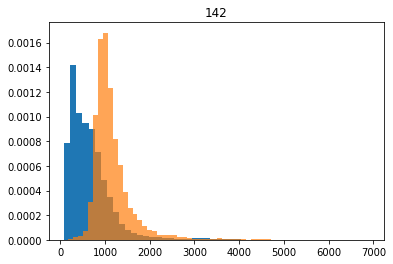

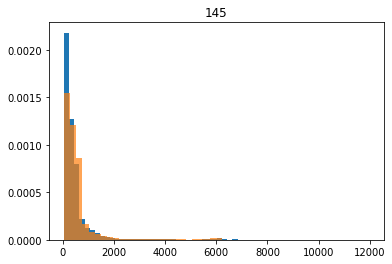

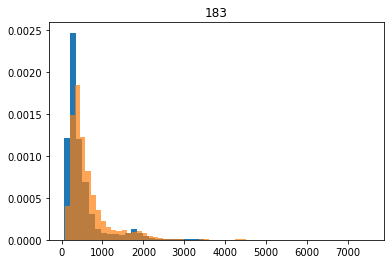

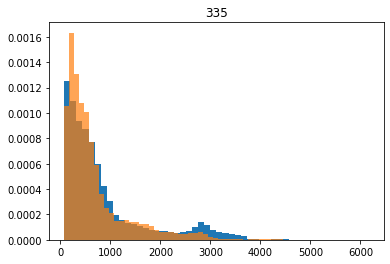

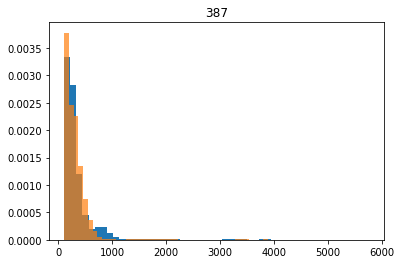

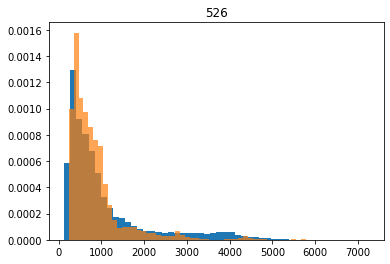

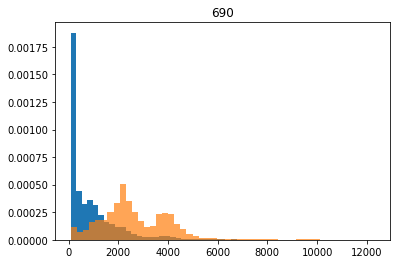

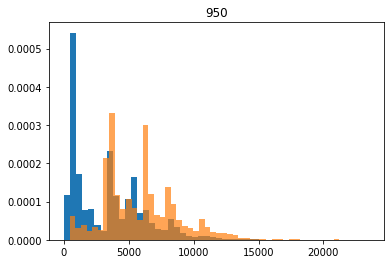

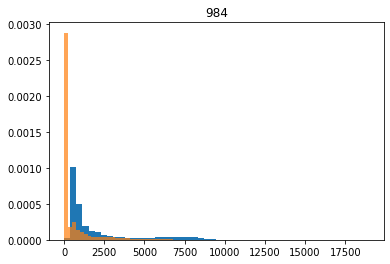

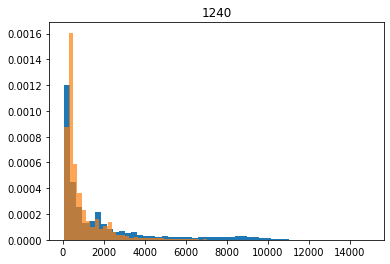

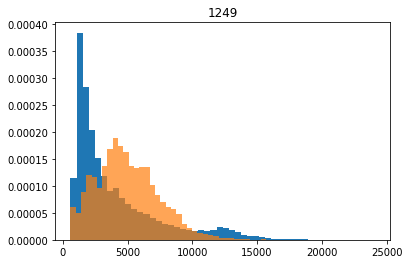

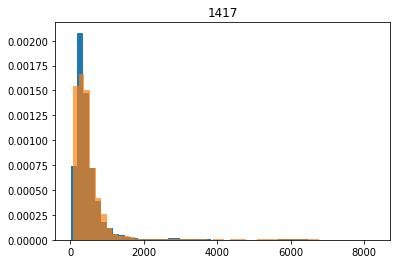

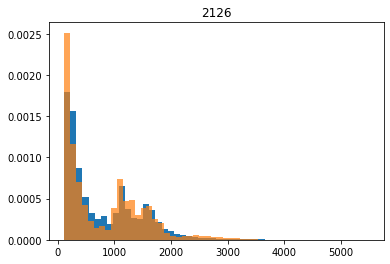

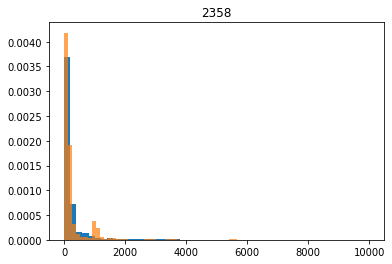

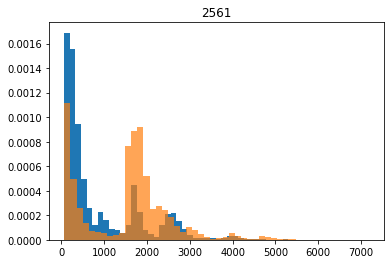

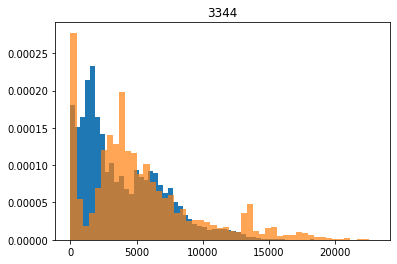

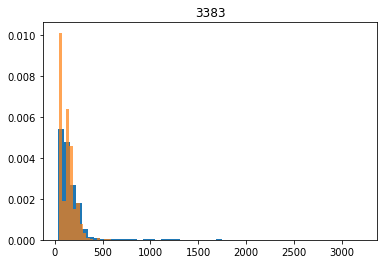

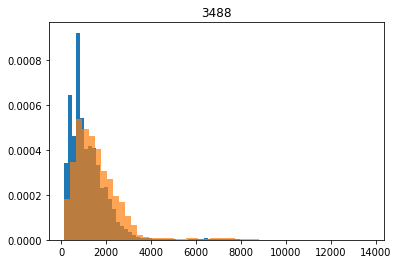

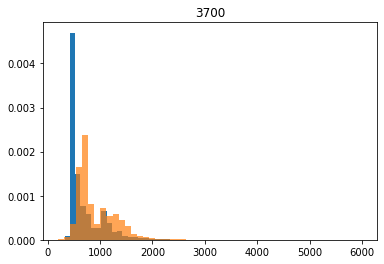

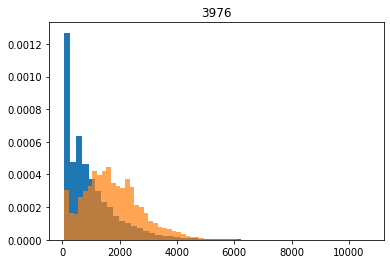

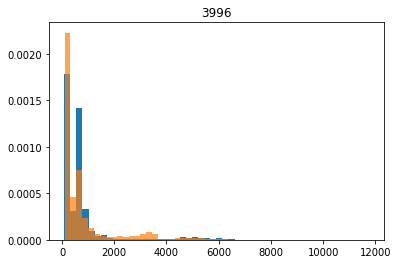

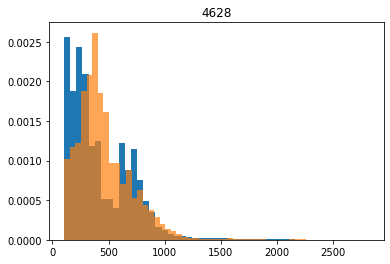

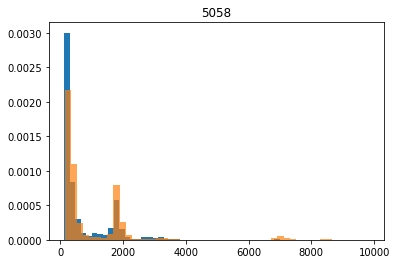

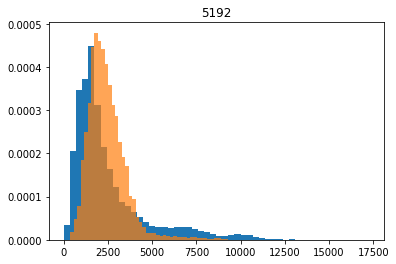

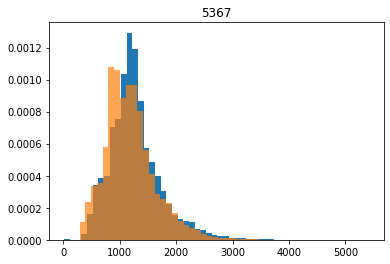

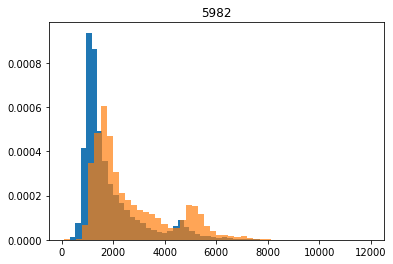

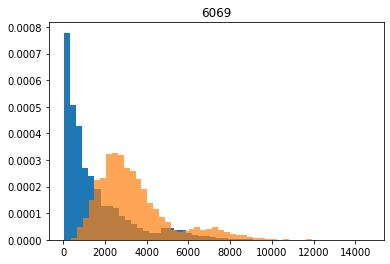

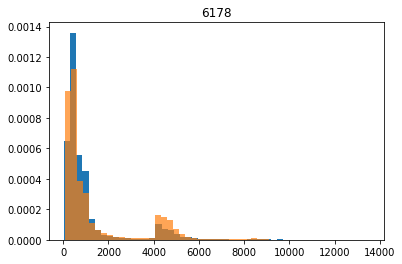

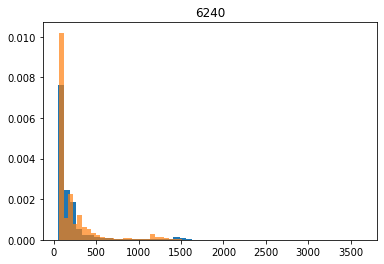

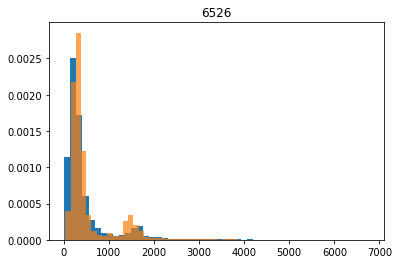

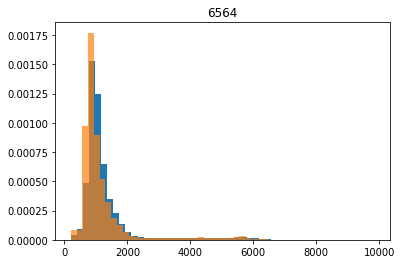

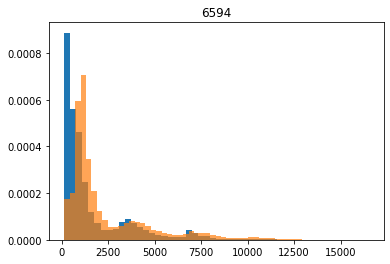

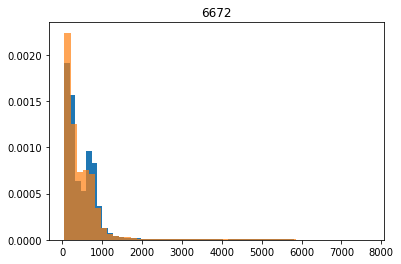

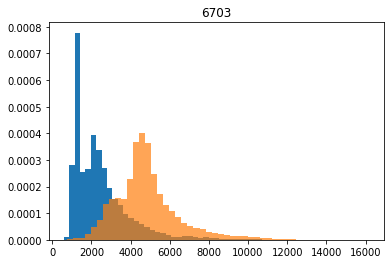

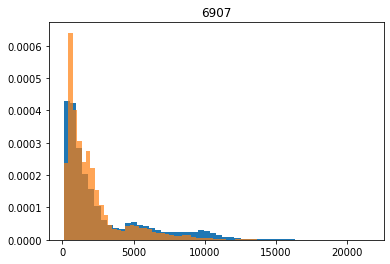

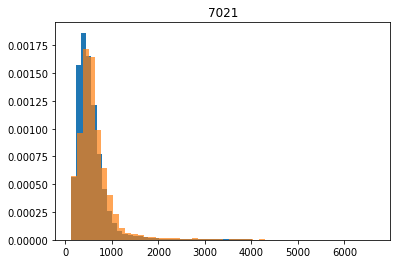

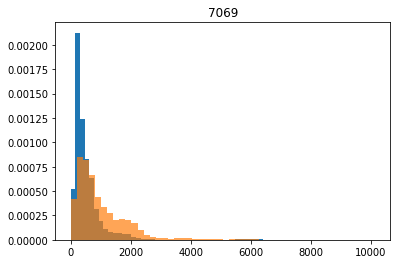

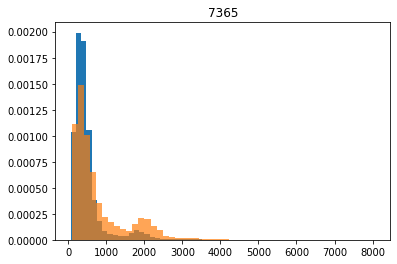

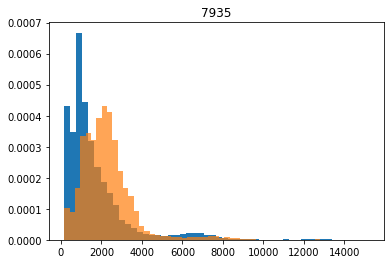

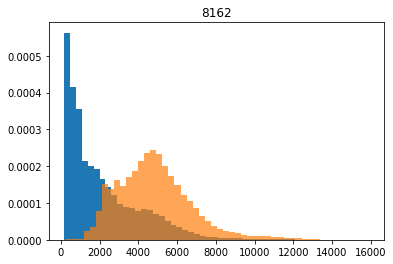

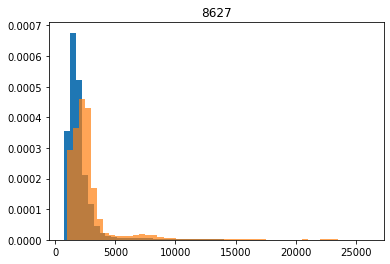

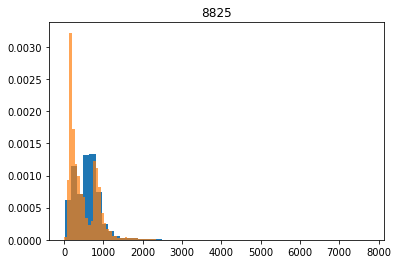

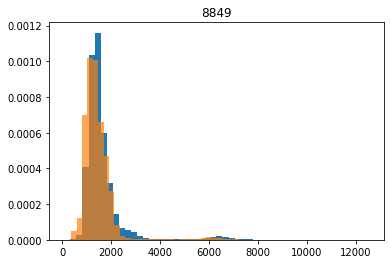

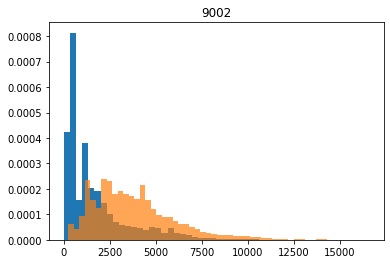

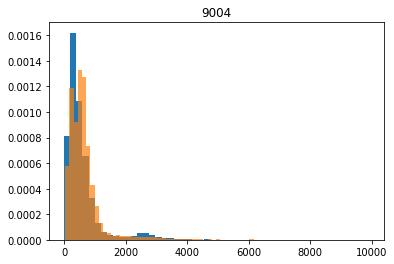

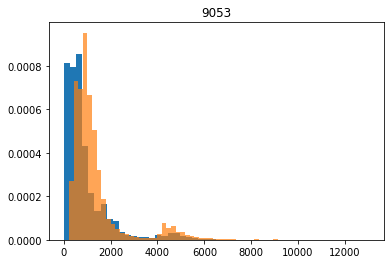

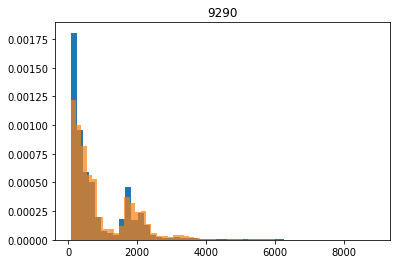

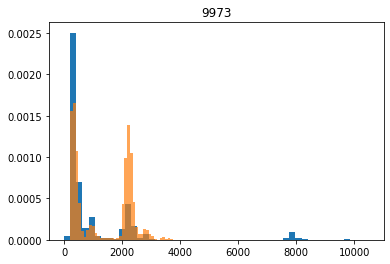

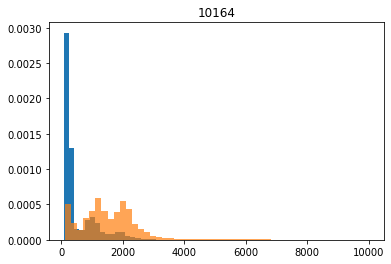

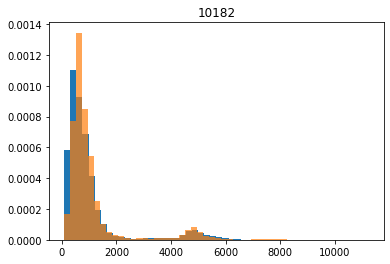

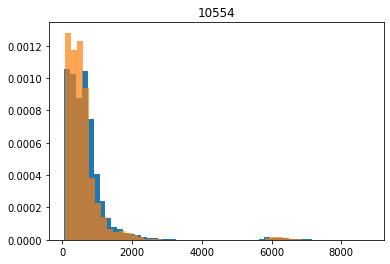

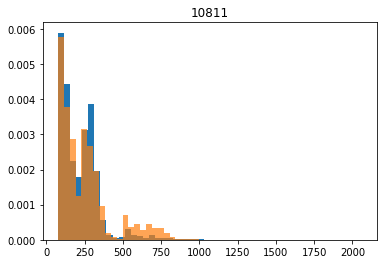

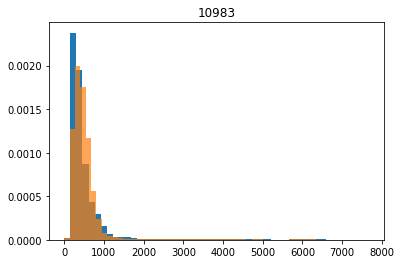

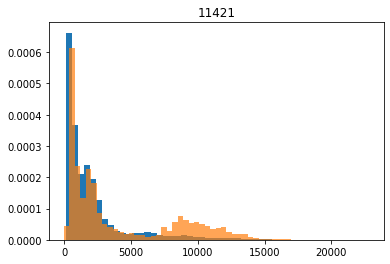

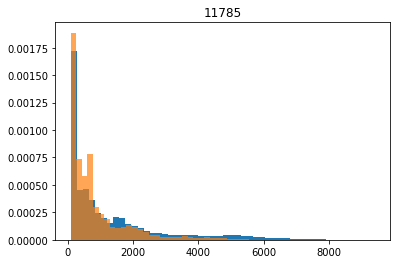

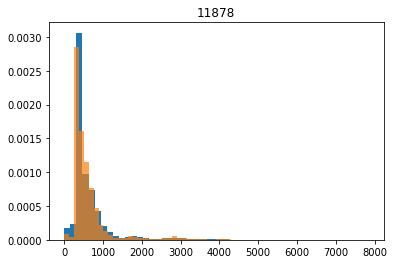

In [30]:
for i in house_ids:
    plt.figure()
    plt.hist(df_fridge.loc[df_fridge.dataid==i]['net_power'].values, bins = 50, density = True)
    plt.hist(df_fridge_dec.loc[df_fridge_dec.dataid==i]['net_power'].values[0:int(0.75*len(df_fridge_dec.loc[df_fridge_dec.dataid==i]['net_power'].values))], bins = 50, alpha=0.7, density = True)
    plt.title(i)

C:\Users\aar245\AppData\Local\Temp\2/ipykernel_1292200/1764493549.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


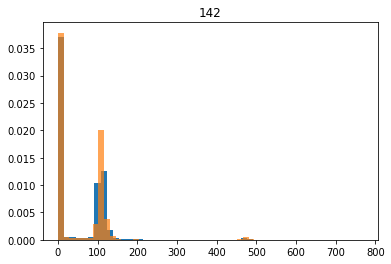

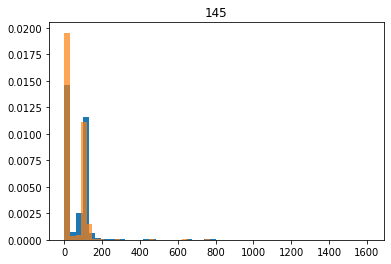

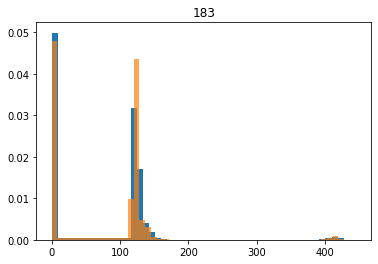

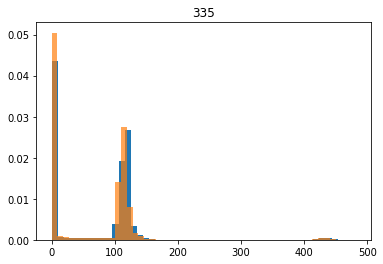

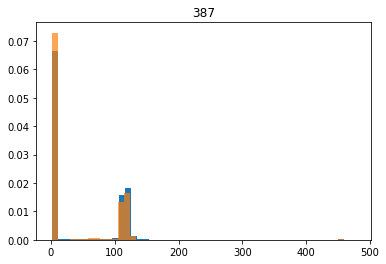

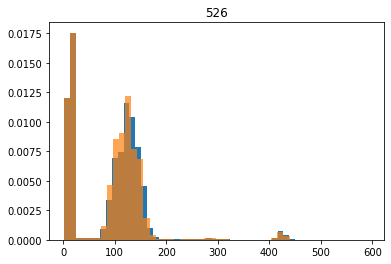

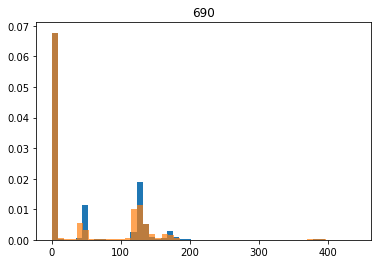

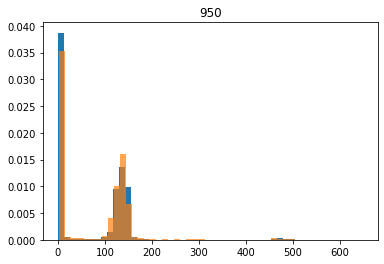

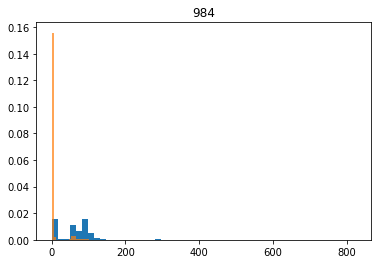

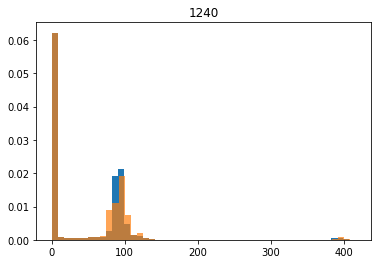

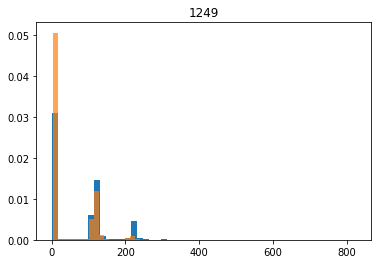

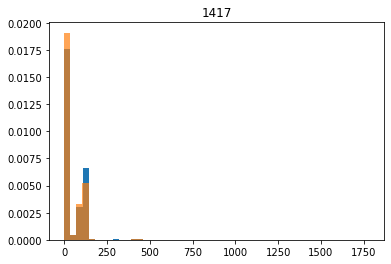

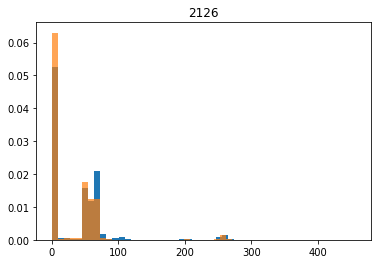

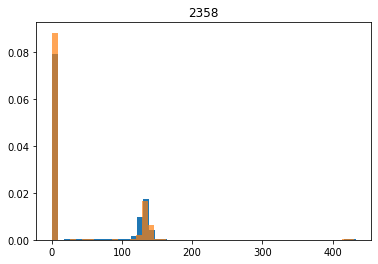

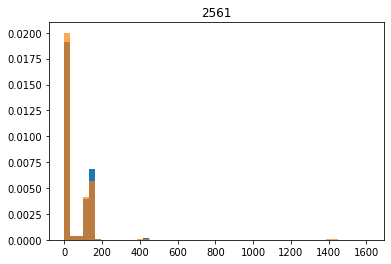

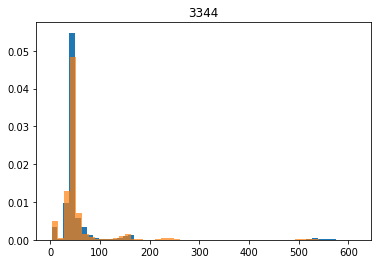

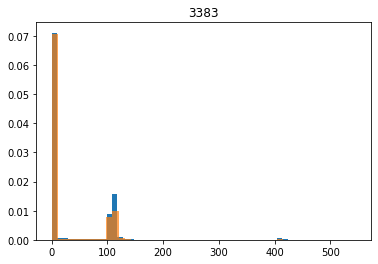

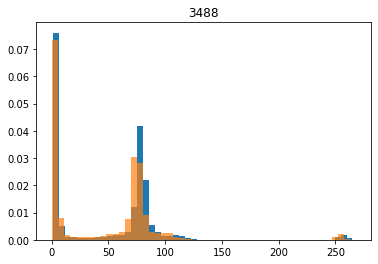

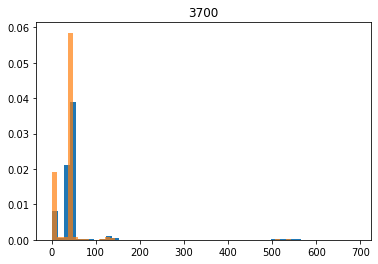

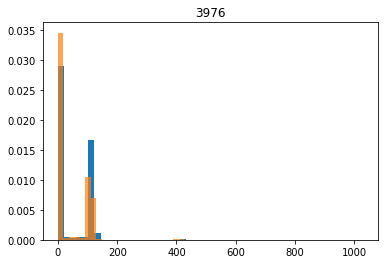

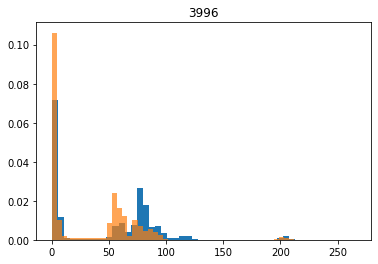

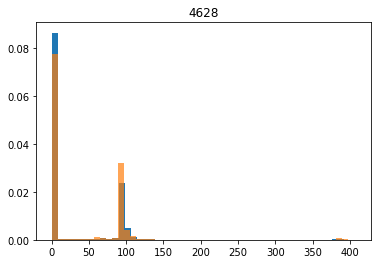

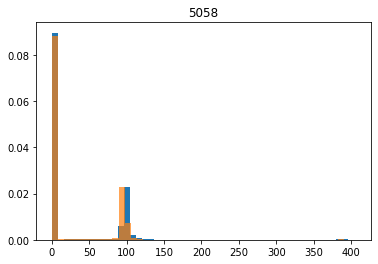

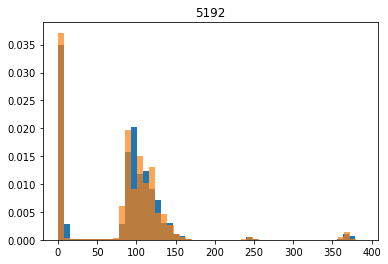

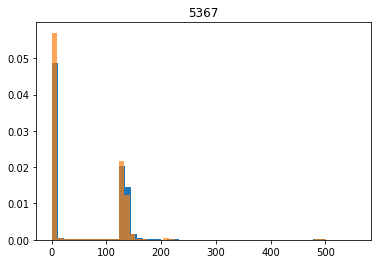

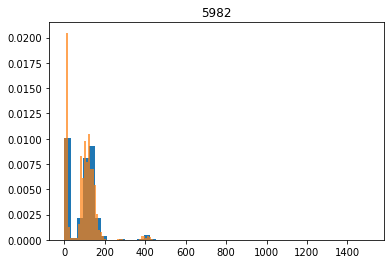

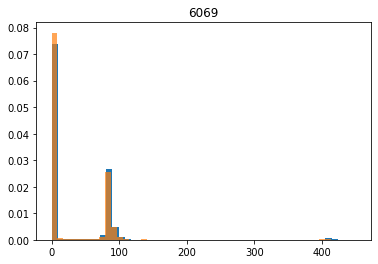

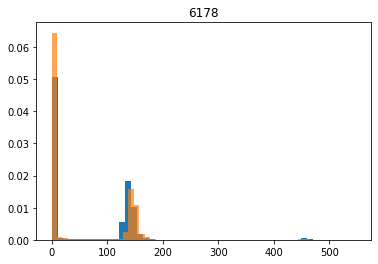

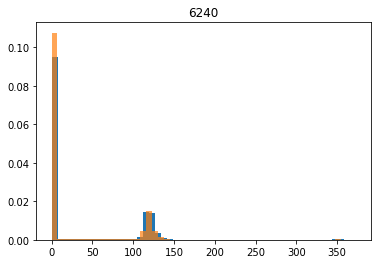

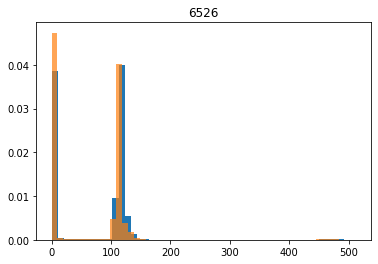

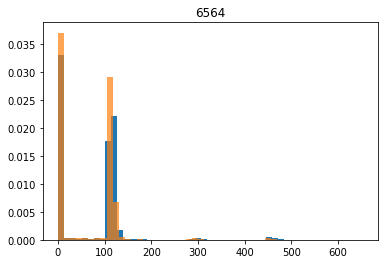

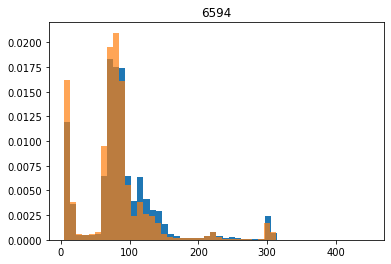

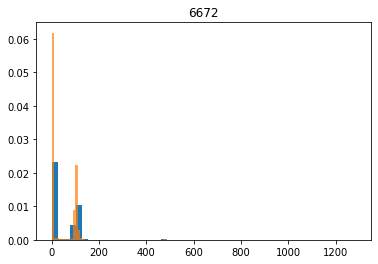

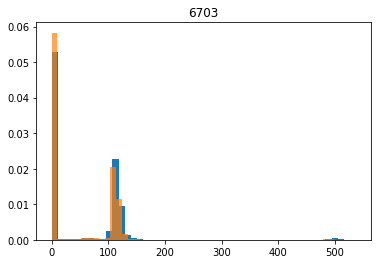

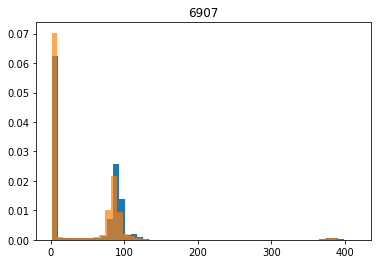

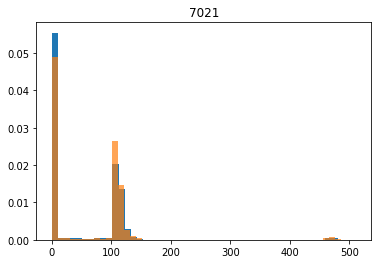

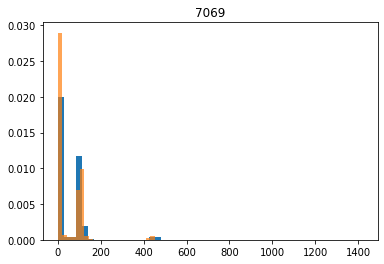

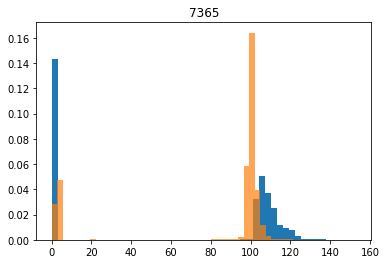

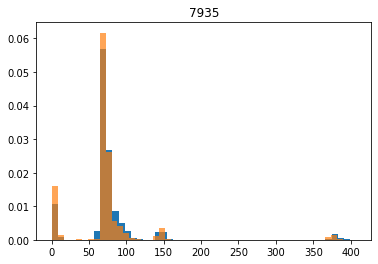

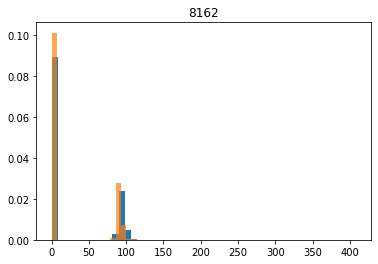

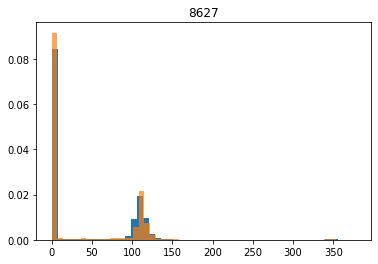

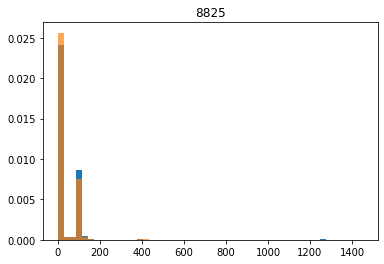

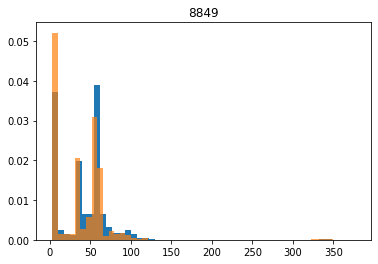

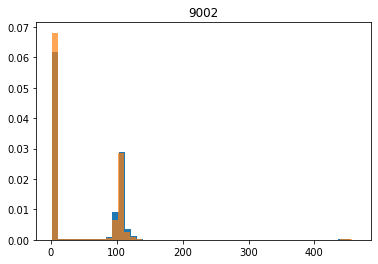

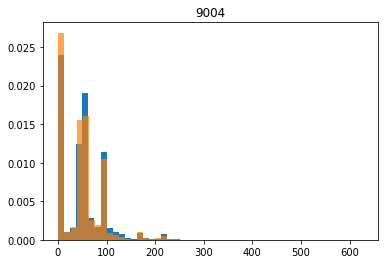

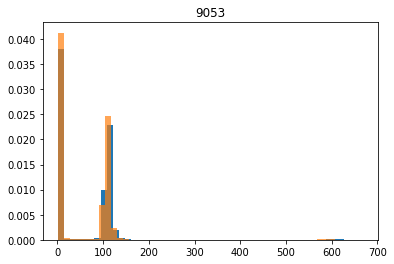

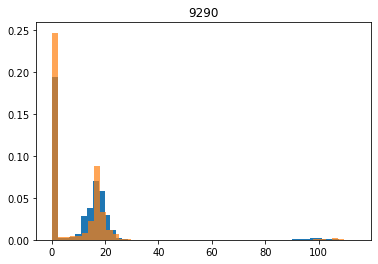

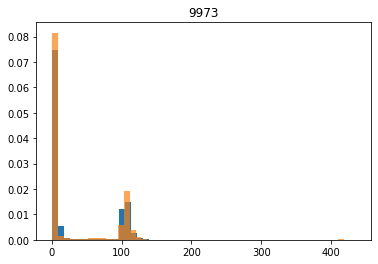

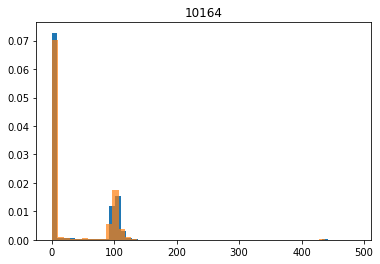

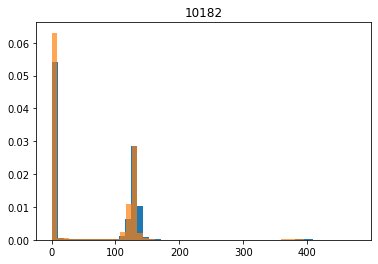

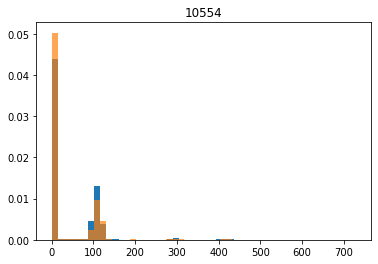

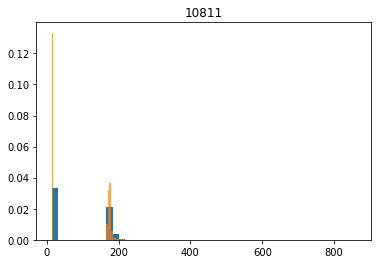

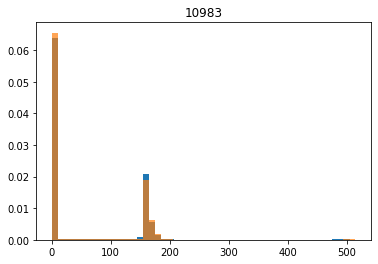

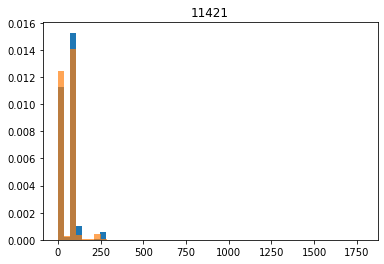

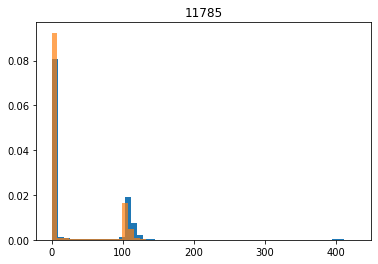

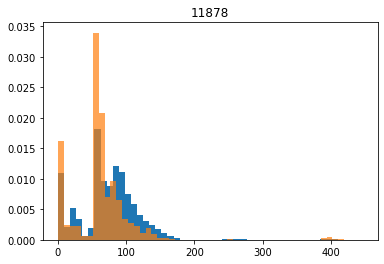

In [28]:
for i in house_ids:
    plt.figure()
    plt.hist(df_fridge.loc[df_fridge.dataid==i]['appliance_power'].values, bins = 50, density = True)
    plt.hist(df_fridge_dec.loc[df_fridge_dec.dataid==i]['appliance_power'].values, bins = 50, alpha=0.7, density = True)
    plt.title(i)

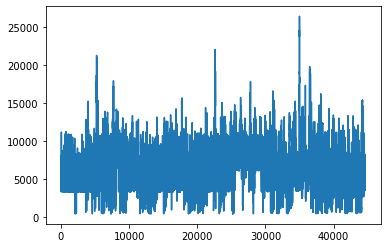

In [23]:
plt.plot(df_fridge_dec.loc[df_fridge_dec.dataid==950]['net_power'].values)

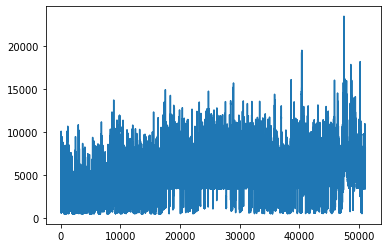

In [27]:
plt.plot(df_fridge.loc[df_fridge.dataid==950]['net_power'].values[80000:])

In [32]:
test_dataset = pd.read_csv(path_dec)

In [40]:
pd.to_datetime(test_dataset.localminute[0])

Timestamp('2019-12-01 00:00:00')

In [42]:
test_dataset['time'] =  pd.to_datetime(test_dataset['localminute'])

In [47]:
test_dataset = test_dataset.loc[test_dataset.time<'2019-12-20']

In [52]:
test_dataset.drop(['time'], axis=1).to_csv(r"C:\Users\aar245\Desktop\input\1min_real_dec1thru20_2019.csv", index=False)

## Creating K-means groupings

In [ ]:
squ_foot = pd.read_csv(
    r"C:\Users\aar245\Desktop\input\1min_real_sept_oct_nov2019_new.csv",
    usecols = ['dataid', 'total_square_footage']
)

In [ ]:
squ_foot = squ_foot.dropna().reset_index(drop=True)

In [ ]:
squ_foot = squ_foot.groupby(squ_foot.dataid).mean()

In [ ]:
squ_foot

In [ ]:
plt.hist(squ_foot[squ_foot < 4000].values, bins=20)

In [ ]:
squ_foot_filtered = squ_foot[squ_foot['total_square_footage'] < 4000]

In [ ]:
squ_foot_mean = np.mean(squ_foot_filtered.values)

In [ ]:
squ_foot_std = np.std(squ_foot_filtered.values)

In [ ]:
squ_foot_range = [squ_foot_mean - squ_foot_std, squ_foot_mean + squ_foot_std]

In [ ]:
squ_foot_filtered = squ_foot[squ_foot['total_square_footage'] < squ_foot_range[1]]

In [ ]:
squ_foot_filtered = squ_foot[squ_foot['total_square_footage'] > squ_foot_range[0]]

In [ ]:
avg_powers = df_fridge.groupby(df_fridge.dataid).mean()

In [ ]:
avg_powers['total_square_footage'] = squ_foot_filtered

In [ ]:
avg_powers = avg_powers.dropna()

In [ ]:
#houses to keep
[  142,   183,   335,   387,   526,  1240,  1417,  2126,  2358,
             3383,  3488,  3976,  3996,  5058,  5192,  6069,  6178,  6240,
             6526,  6564,  6594,  6672,  6703,  7069,  7365,  7935,  8627,
             8825,  9002,  9004,  9053,  9290, 10182, 10811, 10983, 11421,
            11785, 11878]

In [ ]:
plt.scatter(avg_powers.net_power.values, avg_powers.appliance_power.values)

In [ ]:
plt.hist(avg_powers.appliance_power.values)

In [ ]:
X = np.array(list(list(a) for a in zip(avg_powers.net_power.values, avg_powers.appliance_power.values)))

In [ ]:
WCSS = []
for i in range(1,26):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(avg_powers.values)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(25),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(25))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
for i in range(len(WCSS)-1):
    print((WCSS[i+1] - WCSS[i])/WCSS[i])

In [ ]:
kmeans = KMeans(n_clusters=8, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0).fit(avg_powers.values)

In [ ]:
label = kmeans.fit_predict(avg_powers.values)

In [ ]:
sns.countplot(label)

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'orange', 'green', '#D12B60', 'purple', 'yellow', 'red', 'black']
for j in range(len(set(label))):
    ax.scatter(avg_powers.values[label == j,0],avg_powers.values[label == j,1],avg_powers.values[label == j,2], s=40, color=colors[j], label="cluster "+str(j))
ax.set_xlabel('Avg net power-->')
ax.set_ylabel('Avg appliance power-->')
ax.set_zlabel('Total square footage-->')
ax.legend()
plt.show()

In [ ]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(avg_powers[label == i , 0] , avg_powers[label == i , 1] , label = i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("avg_aggregate_power (W)")
plt.ylabel("avg_appliance_power (W)")
plt.show()

In [ ]:
data = list(zip(avg_agg.index, label))

## Calculating averge energy

In [ ]:
avg_agg_energy = grid.groupby(grid.dataid).mean()

In [ ]:
avg_agg_energy = avg_agg_energy.drop(index=homes_to_drop)

In [ ]:
avg_agg_energy['total_length'] = total_lengths

In [ ]:
avg_agg_energy = avg_agg_energy.sort_values(by='total_grid', ascending=False)

In [ ]:
# kilowatthours consumed by each home for sept, oct, nov
plt.figure(figsize=(10,5))
plt.bar(avg_agg_energy.index.astype(str), avg_agg_energy.total_grid.values*avg_agg_energy.total_length.values/60/1000)
plt.plot(avg_agg_energy.index.astype(str), [2679]*len(avg_agg_energy))
plt.plot(avg_agg_energy.index.astype(str), [np.mean(avg_agg_energy.total_grid.values*avg_agg_energy.total_length.values/60/1000)]*len(avg_agg_energy))
plt.legend(['National Average', 'Dataset Average'])
plt.xticks(rotation=90)

In [ ]:
FL_results = [[0.06951961666345596, -1.0547907920686839, 0.7311992588450115, 0.7456100673854843, 0.45352463815322563, 19.315455238024395],
 [0.06750611960887909, -0.9061764415008356, 0.7431598779071023, 0.7048023497628592, 0.4403891934243316, 18.258307973543804],
 [0.04297441616654396, -0.6392584912691109, 0.8125841782201447, 0.4744438811163561, 0.2803518699064789, 12.290740092595419],
 [0.07527746260166168, -1.1321102858024428, 0.7133773582568644, 0.7908635820821566, 0.49108701108305475, 20.487773418426514],
 [0.06078772619366646, -0.9909178343987756, 0.7560586497334231, 0.6352026388321399, 0.3965604598159795, 16.4552876551946],
 [0.06729450821876526, -1.1279164035403797, 0.7078740864442855, 0.7361251794856674, 0.4390087399870242, 19.069743792215984],
 [0.03205053508281708, 0.2828068573659976, 0.7832790662095058, 0.42367462842894427, 0.20908782968145428, 10.975533564885458],
 [0.03972587361931801, 0.00046629515384349896, 0.7347972250315615, 0.48810910100089355, 0.2591594291053503, 12.644745429356893],
 [0.03881887346506119, 0.10475708558699538, 0.7167735279518588, 0.49345413640767144, 0.2532424364276869, 12.783211628595987],
 [0.044760655611753464, -0.1677143401281589, 0.6904550401939484, 0.540701311319558, 0.2920047632228599, 14.007176717122396],
 [0.04850225895643234, 0.05459620717059697, 0.7148736055951348, 0.5115025474377614, 0.3164138529907328, 13.250766038894653],
 [0.04988951236009598, 0.030102795840318237, 0.715130458322368, 0.5244570155533159, 0.32546384098156134, 13.586358944574991],
 [0.0633954107761383, -0.047742737008218315, 0.6740045526960716, 0.6332575540069433, 0.41357218055692735, 16.40489912033081],
 [0.06450808048248291, -0.09526510258711278, 0.6491365343570882, 0.6276351688916061, 0.42083087357915144, 16.25924801826477],
 [0.06549400091171265, -0.19760707133527125, 0.6671337254158477, 0.6168143856732332, 0.4272627511257778, 15.97892944018046],
 [0.05474377050995827, -0.1290505136790722, 0.696677594833347, 0.5843581071749195, 0.3571315516785887, 15.138130982716879],
 [0.06714557856321335, -0.1691848869123519, 0.6660485223422357, 0.6555396596983776, 0.43803713171654163, 16.9821298122406],
 [0.055342722684144974, -0.014301236927656094, 0.6970973325733955, 0.5805985456244764, 0.3610389377675811, 15.040737390518188],
 [0.059734467417001724, -0.03992679593688886, 0.6858098351038175, 0.5994954767458252, 0.38968928660048263, 15.530273199081421],
 [0.08048170059919357, -1.4764057743724204, 0.45971914384046236, 1.727740589820461, 0.5250378801530454, 44.758108139038086]]

In [ ]:
unwanted = {'dataid', 'leg1v', 'leg2v', 'grid', 'solar', 'solar2', "localminute"}

In [ ]:
appliances = [x for x in df.columns if x not in unwanted]